# Homework 2 - IEEE Fraud Detection

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys
import re
from collections import Counter
from sklearn import metrics, preprocessing
import datetime
import altair as alt
import matplotlib.ticker as ticker
from sklearn import preprocessing
import xgboost as xgb
pd.options.display.float_format = '{:,.3f}'.format

In [46]:
from google.colab import drive
drive.mount("/content/drive",force_remount = True)

Mounted at /content/drive


## Part 1 - Fraudulent vs Non-Fraudulent Transaction

In [47]:
#input location according to my drive location
%%time
train_identity = pd.read_csv('/content/drive/My Drive/DS_HW1/ieee-fraud-detection/train_identity.csv')
train_transaction = pd.read_csv('/content/drive/My Drive/DS_HW1/ieee-fraud-detection/train_transaction.csv')
test_identity = pd.read_csv('/content/drive/My Drive/DS_HW1/ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('/content/drive/My Drive/DS_HW1/ieee-fraud-detection/test_transaction.csv')

CPU times: user 1min 3s, sys: 2.78 s, total: 1min 6s
Wall time: 1min 7s


In [48]:
#analysing the data set

print('train_identity shape:',train_identity.shape, test_identity.shape)
print('train_transaction shape',train_transaction.shape, test_transaction.shape)
print('number of unique transaction IDs in train_transaciton:',len(train_transaction['TransactionID'].unique().tolist()))
print('number of unique transaction IDs in train_identity:',len(train_identity['TransactionID'].unique().tolist()))

missing_transactions_train_identity = list(set(train_transaction['TransactionID'].unique().tolist()) - 
                                           set(train_identity['TransactionID'].unique().tolist()))
print('number of transaction IDs present in train_transaction but not in train_identity:',len(missing_transactions_train_identity))

print('number of unique transaction IDs in test_transaciton:',len(test_transaction['TransactionID'].unique().tolist()))
print('number of unique transaction IDs in test_identity:',len(test_identity['TransactionID'].unique().tolist()))

missing_transactions_test_identity = list(set(test_transaction['TransactionID'].unique().tolist()) - 
                                          set(test_identity['TransactionID'].unique().tolist()))
print('number of transaction IDs present in test_transaction but not in test_identity:',len(missing_transactions_test_identity))

train_identity shape: (144233, 41) (141907, 41)
train_transaction shape (590540, 394) (506691, 393)
number of unique transaction IDs in train_transaciton: 590540
number of unique transaction IDs in train_identity: 144233
number of transaction IDs present in train_transaction but not in train_identity: 446307
number of unique transaction IDs in test_transaciton: 506691
number of unique transaction IDs in test_identity: 141907
number of transaction IDs present in test_transaction but not in test_identity: 364784


Since isFraud is not present in train_identity.csv, hence merging it with train_transaction.csv on the basis of transaction id to get better analysis

In [0]:
train_trn_id_merged = pd.merge(train_transaction, train_identity, on=['TransactionID'], how='inner')
test_trn_id_merged = pd.merge(test_transaction, test_identity, on=['TransactionID'], how='inner')

we see that only 144233 transaction IDs from train_transaction.csv are present in train_identity.csv, so isFraud information is available only for 144233 transaction IDs in the train_identity.csv file

In [50]:
print('number of unique transaction IDs from train_transaciton present in train_identity as well:',train_trn_id_merged.shape)
print('number of unique transaction IDs from test_transaciton present in test_identity as well:',test_trn_id_merged.shape)
missing_transactions_train_identity = list(set(train_identity['TransactionID'].unique().tolist()) 
                                           - set(train_trn_id_merged['TransactionID'].unique().tolist()))
print('number of identity transaction IDs missing form train_identity after merge:',len(missing_transactions_train_identity))
missing_transactions_test_identity = list(set(test_identity['TransactionID'].unique().tolist()) 
                                          - set(test_trn_id_merged['TransactionID'].unique().tolist()))
print('number of identity transaction IDs missing form test_identity after merge:',len(missing_transactions_test_identity))

number of unique transaction IDs from train_transaciton present in train_identity as well: (144233, 434)
number of unique transaction IDs from test_transaciton present in test_identity as well: (141907, 433)
number of identity transaction IDs missing form train_identity after merge: 0
number of identity transaction IDs missing form test_identity after merge: 0


1. we see that only 144233 transaction IDs from train_transaction.csv are present in train_identity.csv, so isFraud information is available only for 144233 transaction IDs in the train_identity.csv file.
2. we see that only 141907 transaction IDs from test_transaction.csv are present in test_identity.csv.
3. Also, all transactions present in identity files are present in transaction files but not vice versa.

**Distribution of fradulent and non fradulent data in train_transaction.csv**

,0,1
isFraud,0.965,0.035


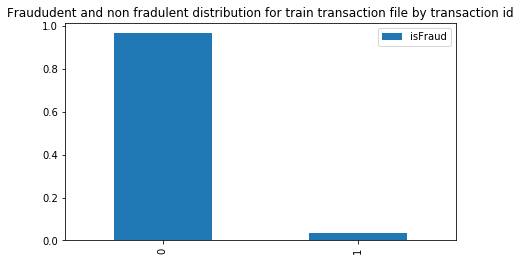

In [51]:
fraud_train_transaction = train_transaction['isFraud'].value_counts(normalize=True).to_frame()
fraud_train_transaction.plot(kind='bar', figsize=(7,4), fontsize=10,
                             title='Fraududent and non fradulent distribution for train transaction file by transaction id')
fraud_train_transaction.T

**We obsrve that in train_transaction.csv file we have only 3.5% of fradulent data, rest all are normal transactions.**

**Distribution of fradulent and non fradulent data in train_identity.csv after getting fradulent information from train_transaction.csv**

,0,1
isFraud,0.922,0.078


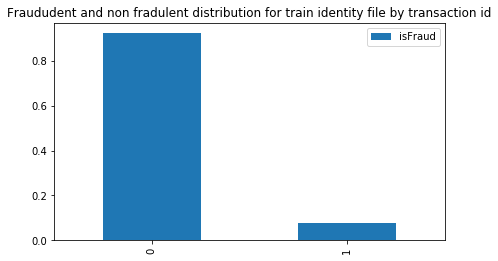

In [52]:
fraud_train_identity = train_trn_id_merged['isFraud'].value_counts(normalize=True).to_frame()
fraud_train_identity.plot(kind='bar', figsize=(7,4), fontsize=10,
                          title='Fraududent and non fradulent distribution for train identity file by transaction id')
fraud_train_identity.T

**Here we used the merged data to find fradulent transactions in train_identity.csv and we observe that 7.8% of transactions are fradulent**

* **Analysis on basis of device type**

In [53]:
#Getting device type information
device_type_list = train_trn_id_merged['DeviceType'].tolist()
print('number of unique device type:',len((train_trn_id_merged['DeviceType'].unique().tolist())))

#getting top device types and number of transactions without device types
top_device_type = Counter(device_type_list).most_common(3)
top_devices = []
for item in top_device_type:
    if str(item[0]) != 'nan':
        top_devices.append(str(item[0]))
    else:
        no_device_type_info=item[1]
print('top used devices info:',top_devices)
print('number of transactions with no device info:',no_device_type_info)


number of unique device type: 3
top used devices info: ['desktop', 'mobile']
number of transactions with no device info: 3423


DeviceType desktop       mobile      
isFraud          0     1      0     1
isFraud      0.935 0.065  0.898 0.102

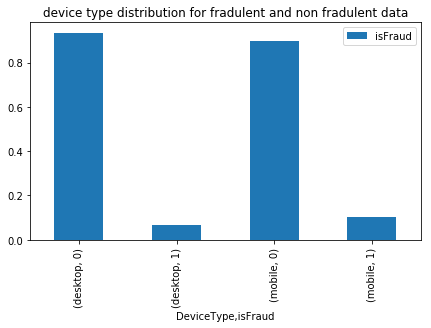

In [54]:
device_type_distribution = train_trn_id_merged.groupby('DeviceType')['isFraud'].value_counts(normalize=True).to_frame()
device_type_distribution.plot(kind='bar', figsize=(7,4), fontsize=10,title='device type distribution for fradulent and non fradulent data')
device_type_distribution.T

1. From the above distribution it is observed that 89.8% mobile transactions are not fradulent
2. 93.5% desktop transactions are not fradulent
3. 10.2% of mobile transactions are fradulent
4. 6.5% of desktop transactions are fradulent

**Analysis on basis of device info**

DeviceInfo
Windows                  47722
iOS Device               19782
MacOS                    12573
Trident/7.0               7440
rv:11.0                   1901
rv:57.0                    962
SM-J700M Build/MMB29K      549
SM-G610M Build/MMB29K      461
SM-G531H Build/LMY48B      410
rv:59.0                    362
Name: TransactionID, dtype: int64

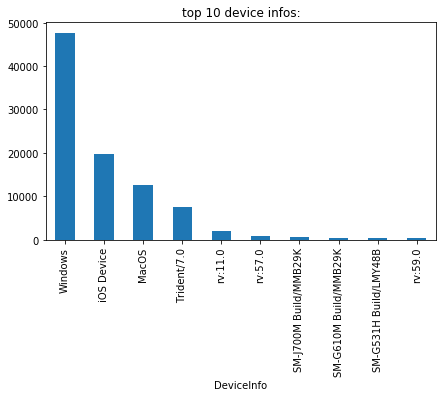

In [55]:
#Getting the top 10 devices

top_devices=train_trn_id_merged.groupby('DeviceInfo').count()['TransactionID'].sort_values(ascending=False).head(10)
top_devices.plot(kind='bar', figsize=(7,4), fontsize=10,title='top 10 device infos:')
top_devices.T

In [56]:
#Getting device info information

device_list = train_trn_id_merged['DeviceInfo'].tolist()
print('number of unique devices:',len(train_trn_id_merged['DeviceInfo'].unique().tolist()))
top_popular_device_info = Counter(device_list).most_common(4)
top_3_devices = []
for item in top_popular_device_info:
    if str(item[0]) != 'nan':
        top_3_devices.append(str(item[0]))
    else:
        no_device_info=item[1]
print('top 3 used devices info:',top_3_devices)
print('number of transactions with no device info:',no_device_info)

number of unique devices: 1787
top 3 used devices info: ['Windows', 'iOS Device', 'MacOS']
number of transactions with no device info: 25567


**Fradulent and non fradulent data distribution for the top 3 devices**

**1. Distribution for the top most used device info**

DeviceInfo Windows      
isFraud          0     1
isFraud      0.935 0.065

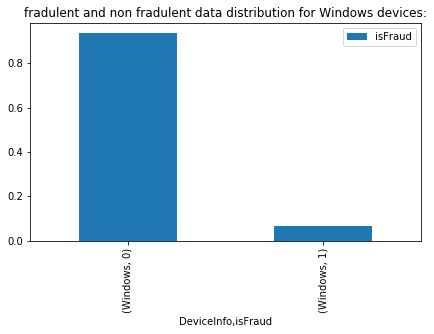

In [57]:
title_desc = 'fradulent and non fradulent data distribution for '+str(top_3_devices[0])+' devices:'
device_info_distribution = train_trn_id_merged[train_trn_id_merged['DeviceInfo'] == 
                                               top_3_devices[0]].groupby('DeviceInfo')['isFraud'].value_counts(normalize=True).to_frame()
device_info_distribution.plot(kind='bar', figsize=(7,4), fontsize=10, title=title_desc)
device_info_distribution.T

The top most device info was Windows.

1. it is observed that 6.5% of transactions made from windows device is fradulent
2. 93.5% of transactions made from windows device is non-fradulent

**2. Distribution for the second most used device info**

DeviceInfo iOS Device      
isFraud             0     1
isFraud         0.937 0.063

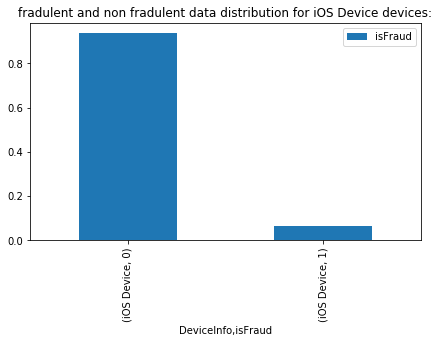

In [58]:
title_desc = 'fradulent and non fradulent data distribution for '+str(top_3_devices[1])+' devices:'
device_info_distribution = train_trn_id_merged[train_trn_id_merged['DeviceInfo'] == 
                                               top_3_devices[1]].groupby('DeviceInfo')['isFraud'].value_counts(normalize=True).to_frame()
device_info_distribution.plot(kind='bar', figsize=(7,4), fontsize=10, title=title_desc)
device_info_distribution.T

The second most used device info was Ios devices.

1. it is observed that 6.3% of transactions made from windows device is fradulent
2. 93.7% of transactions made from windows device is non-fradulent

**3. Distribution for the third most used device info**

DeviceInfo MacOS      
isFraud        0     1
isFraud    0.978 0.022

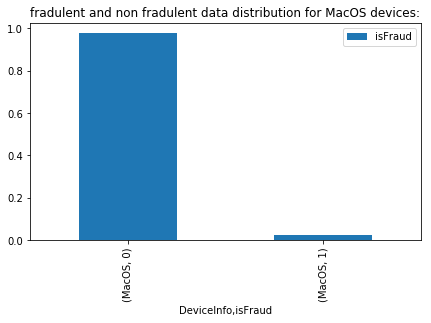

In [59]:
title_desc = 'fradulent and non fradulent data distribution for '+str(top_3_devices[2])+' devices:'
device_info_distribution = train_trn_id_merged[train_trn_id_merged['DeviceInfo'] == 
                                               top_3_devices[2]].groupby('DeviceInfo')['isFraud'].value_counts(normalize=True).to_frame()
device_info_distribution.plot(kind='bar', figsize=(7,4), fontsize=10, title=title_desc)
device_info_distribution.T

The third most used device info was MacOs.

1. it is observed that 2.2% of transactions made from windows device is fradulent
2. 97.8% of transactions made from windows device is non-fradulent

**Thus, MacOS observed the least fraudulent transactions among the top 3**

1. **Analysis on basis of transaction date**

**An important assumption/finding**: If we observe the timeline of the web browser release and also see the hint they gave us in the form of christmas season. We can say that the data is starting from the month of december 2017 and is a year's data till december 2018

In [60]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
train_transaction['Date'] = train_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test_transaction['Date'] = test_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

print(train_transaction['Date'].head())
print(test_transaction['Date'].tail())

0   2017-12-02 00:00:00
1   2017-12-02 00:00:01
2   2017-12-02 00:01:09
3   2017-12-02 00:01:39
4   2017-12-02 00:01:46
Name: Date, dtype: datetime64[ns]
506686   2018-12-31 23:57:59
506687   2018-12-31 23:58:07
506688   2018-12-31 23:58:46
506689   2018-12-31 23:58:57
506690   2018-12-31 23:59:05
Name: Date, dtype: datetime64[ns]


From the above output it could be seen that the data is available till 31-12-2018

Text(0.5, 1.0, 'tranaction date distribution for both test and train data')

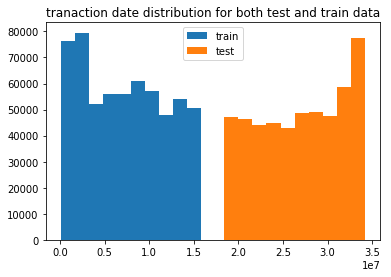

In [61]:
#test and train transaction distribution over time
plt.hist(train_transaction['TransactionDT'], label='train')
plt.hist(test_transaction['TransactionDT'], label='test')
plt.legend()
plt.title('tranaction date distribution for both test and train data')

From the above distribution it is observed that, test and training data do not overlap. Test data is from a later period as compared to the training data.
* **Also, as we can see the peak transactions are at the beginning and end of the distribution. And as we deduced that data starts from December 2017 and goes till December 2018, we can say that peak transactions are during the christmas season.**

**Fraud distribution across a period of time**

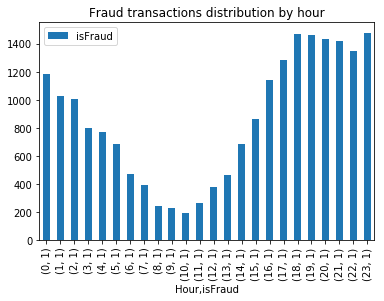

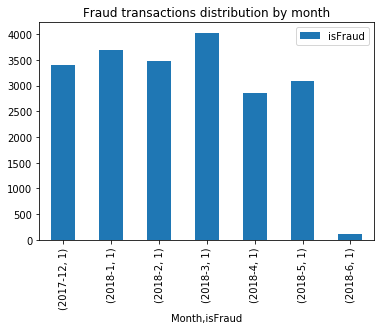

In [62]:
train_transaction['Date'] = train_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

train_transaction['Hour'] = train_transaction['Date'].dt.hour
train_transaction['Month'] = train_transaction['Date'].dt.year.astype(str) + '-' + train_transaction['Date'].dt.month.astype(str)

#fraud transactions by hour for train data
dist_by_hour=train_transaction[train_transaction["isFraud"] == 1].groupby('Hour')['isFraud'].value_counts(normalize=False).to_frame()
dist_by_hour.plot(kind='bar', fontsize=10, title='Fraud transactions distribution by hour')

#fraud transactions by month for train data
dist_by_month = train_transaction[train_transaction["isFraud"] == 1].groupby('Month')['isFraud'].value_counts(normalize=False).to_frame()
dist_by_month.plot(kind='bar', fontsize=10, title='Fraud transactions distribution by month')

* It is observed from the first plot that fraud transactions increase during midnight
* Also, March had the most number of fraud transactions as compared to other months, this may be because season end and high number of vacations

**Analysis of Transaction Amount**

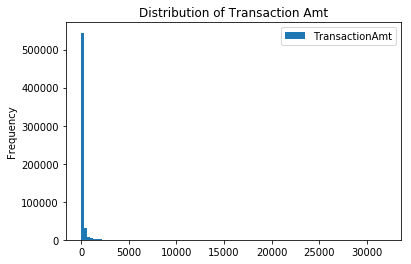

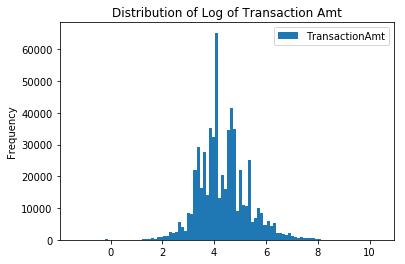

In [63]:
amt_transaction_dist = train_transaction['TransactionAmt'].to_frame()
amt_transaction_dist.plot(kind='hist',bins=100,title='Distribution of Transaction Amt')
#taking log of transaction amount
amt_transaction_dist = train_transaction['TransactionAmt'].apply(np.log).to_frame()
amt_transaction_dist.plot(kind='hist',bins=100,title='Distribution of Log of Transaction Amt')

Its observed that some large transaction amounts just skew the whole transformation, so, taking a log on transaction amounts give us a better distribution.

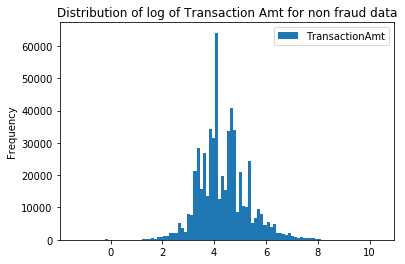

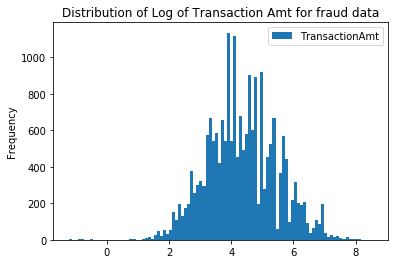

In [64]:
amt_transaction_dist = train_transaction[train_transaction["isFraud"] == 0]['TransactionAmt'].apply(np.log).to_frame()
amt_transaction_dist.plot(kind='hist',bins=100,title='Distribution of log of Transaction Amt for non fraud data')

#distribution for fraudulent data
amt_transaction_dist = train_transaction[train_transaction["isFraud"] == 1]['TransactionAmt'].apply(np.log).to_frame()
amt_transaction_dist.plot(kind='hist',bins=100,title='Distribution of Log of Transaction Amt for fraud data')

**The primary observation here is that the average number of high amount transactions for fradulent data is more than that of non fradulent data**

**Analysis of Product Code**

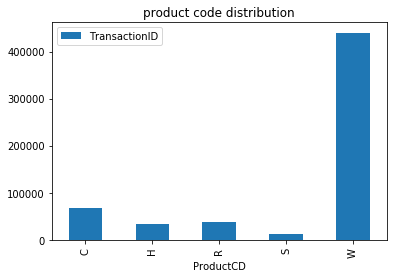

In [65]:
prd_cd_dist = train_transaction.groupby('ProductCD')['TransactionID'].count().to_frame()
prd_cd_dist.plot(kind='bar',title='product code distribution')

Its observed that Product code: W has the most number of records. Also, it's not clear what these product codes mean.
Below is the distribution by fradulent and non fradulent data

ProductCD     C           H           R           S           W      
isFraud       0     1     0     1     0     1     0     1     0     1
isFraud   0.883 0.117 0.952 0.048 0.962 0.038 0.941 0.059 0.980 0.020

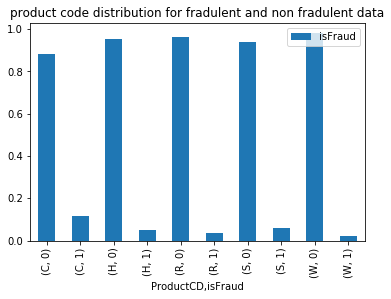

In [66]:
prd_cd_dist = train_transaction.groupby('ProductCD')['isFraud'].value_counts(normalize=True).to_frame()
prd_cd_dist.plot(kind='bar',title='product code distribution for fradulent and non fradulent data')
prd_cd_dist.T

**From the above distribution it is observed that**
* Product Code C has the highest fradulent data with 11.7%
* Product Code W has the lowest fradulent data with 2%

**Analysis of card issuer (Card4)**

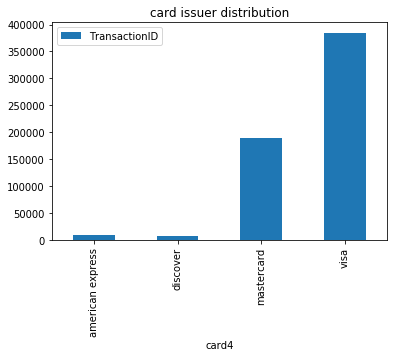

In [67]:
cd4_dist = train_transaction.groupby('card4')['TransactionID'].count().to_frame()
cd4_dist.plot(kind='bar',title='card issuer distribution')

Its observed that Visa is used for maximum number of transactions

card4   american express       discover       mastercard        visa      
isFraud                0     1        0     1          0     1     0     1
isFraud            0.971 0.029    0.923 0.077      0.966 0.034 0.965 0.035

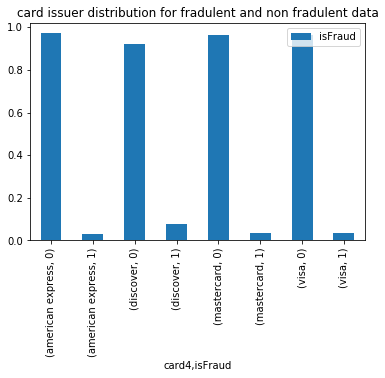

In [68]:
cd4_dist = train_transaction.groupby('card4')['isFraud'].value_counts(normalize=True).to_frame()
cd4_dist.plot(kind='bar',title='card issuer distribution for fradulent and non fradulent data')
cd4_dist.T

**From the above distribution it is observed that**
* Discover card has the highest fradulent data with 7.7%
* American Express has the lowest fradulent data with 2%.

This might be because american express has the strictest card issuance policy and discover's policies aren't that strict.

**Analysis of card 6**

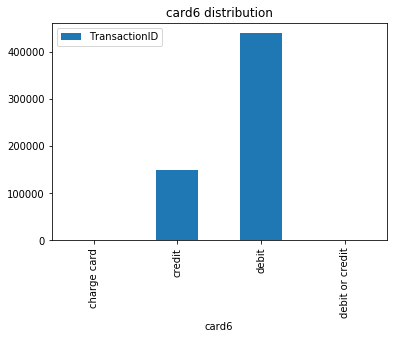

In [69]:
cd6_dist = train_transaction.groupby('card6')['TransactionID'].count().to_frame()
cd6_dist.plot(kind='bar',title='card6 distribution')

Most people use a debit card

card6   charge card credit       debit       debit or credit
isFraud           0      0     1     0     1               0
isFraud       1.000  0.933 0.067 0.976 0.024           1.000

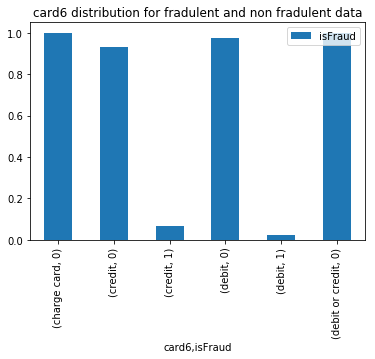

In [70]:
cd6_dist = train_transaction.groupby('card6')['isFraud'].value_counts(normalize=True).to_frame()
cd6_dist.plot(kind='bar',title='card6 distribution for fradulent and non fradulent data')
cd6_dist.T

**From the above distribution it is observed that**
* Credit cards have the highest fradulent data with 6.7%. This is expected as credit cards may not be associated with any bank account.
* Debit cards have the lowest fradulent data with 2.4%.
* Charge and the remaining cards have insufficient data for any analysis

**Analysis of purchaser email domain**

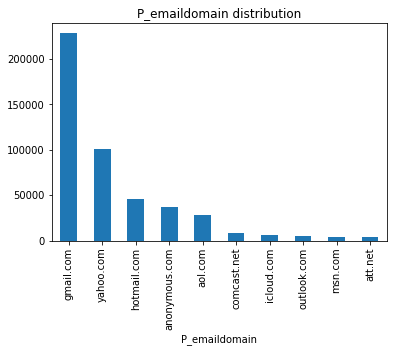

In [71]:
pemail_dist = train_transaction.groupby('P_emaildomain')['TransactionID'].count().sort_values(ascending=False).head(10)
pemail_dist.plot(kind='bar',title='P_emaildomain distribution')

Since there were a lot of email domains, I just captured the top 10 most used email domains by purchasers. Gmail.com has the maximum number of users.

In [72]:
p_e_mail = train_transaction['P_emaildomain'].tolist()
print('number of unique domains:',len(train_transaction['P_emaildomain'].unique().tolist()))
p_e_mail = Counter(p_e_mail).most_common(11)
top_10_email = []
for item in p_e_mail:
    if str(item[0]) != 'nan':
        top_10_email.append(str(item[0]))
    else:
        no_email_info=item[1]
print('top 10 email domain used:',top_10_email)
print('number of transactions with no purchaser email domain:',no_email_info)

number of unique domains: 60
top 10 email domain used: ['gmail.com', 'yahoo.com', 'hotmail.com', 'anonymous.com', 'aol.com', 'comcast.net', 'icloud.com', 'outlook.com', 'msn.com', 'att.net']
number of transactions with no purchaser email domain: 94456


P_emaildomain  isFraud
anonymous.com  0         0.966
               1         0.034
aol.com        0         0.981
               1         0.019
att.net        0         1.000
comcast.net    0         0.981
               1         0.019
gmail.com      0         0.884
               1         0.116
hotmail.com    0         0.921
               1         0.079
icloud.com     0         0.899
               1         0.101
msn.com        0         0.982
               1         0.018
outlook.com    0         0.821
               1         0.179
yahoo.com      0         0.958
               1         0.042
Name: isFraud, dtype: float64

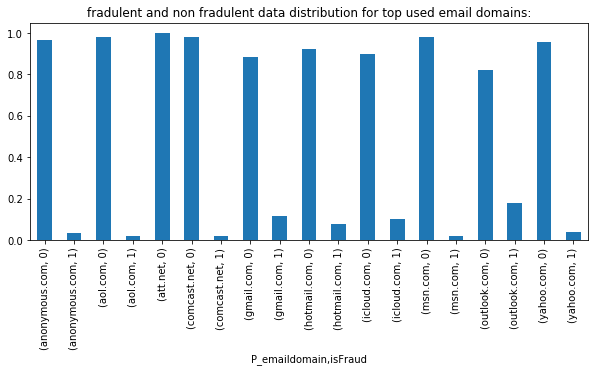

In [74]:
title_desc = 'fradulent and non fradulent data distribution for top used email domains:'
device_info_distribution = train_trn_id_merged[train_trn_id_merged['P_emaildomain'].isin(top_10_email)].groupby('P_emaildomain')['isFraud'].value_counts(normalize=True)
device_info_distribution.to_frame()
device_info_distribution.plot(kind='bar', figsize=(10,4), fontsize=10, title=title_desc)
device_info_distribution.T

**From the above distribution it is observed that**
* Outlook domain has the highest fradulent data with 17.9%, followed by google with 11.6% and icloud with 10.1%
* Out of the most common ones msn.com has the least fradulent data with 1.8%

**Analysis of recepient email domain**

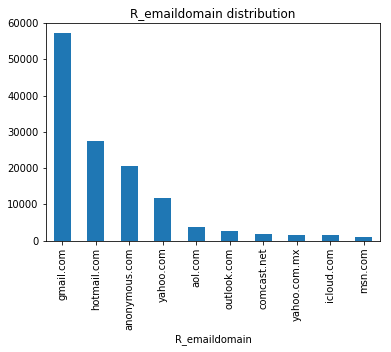

In [75]:
remail_dist = train_transaction.groupby('R_emaildomain')['TransactionID'].count().sort_values(ascending=False).head(10)
remail_dist.plot(kind='bar',title='R_emaildomain distribution')

Since there were a lot of email domains, I just captured the top 10 most used email domains by retailers. Gmail.com has the maximum number of users.

In [76]:
r_e_mail = train_transaction['R_emaildomain'].tolist()
print('number of unique domains:',len(train_transaction['R_emaildomain'].unique().tolist()))
r_e_mail = Counter(r_e_mail).most_common(11)
top_10_email = []
for item in r_e_mail:
    if str(item[0]) != 'nan':
        top_10_email.append(str(item[0]))
    else:
        no_email_info=item[1]
print('top 10 email domain used:',top_10_email)
print('number of transactions with no retail email domain:',no_email_info)

number of unique domains: 61
top 10 email domain used: ['gmail.com', 'hotmail.com', 'anonymous.com', 'yahoo.com', 'aol.com', 'outlook.com', 'comcast.net', 'yahoo.com.mx', 'icloud.com', 'msn.com']
number of transactions with no retail email domain: 453249


R_emaildomain  isFraud
anonymous.com  0         0.971
               1         0.029
aol.com        0         0.965
               1         0.035
comcast.net    0         0.988
               1         0.012
gmail.com      0         0.880
               1         0.120
hotmail.com    0         0.918
               1         0.082
icloud.com     0         0.870
               1         0.130
msn.com        0         0.999
               1         0.001
outlook.com    0         0.831
               1         0.169
yahoo.com      0         0.949
               1         0.051
yahoo.com.mx   0         0.993
               1         0.007
Name: isFraud, dtype: float64

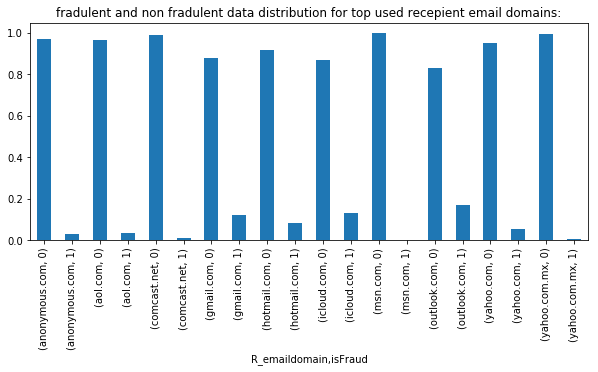

In [78]:
title_desc = 'fradulent and non fradulent data distribution for top used recepient email domains:'
device_info_distribution = train_trn_id_merged[train_trn_id_merged['R_emaildomain'].isin(top_10_email)].groupby('R_emaildomain')['isFraud'].value_counts(normalize=True)
device_info_distribution.to_frame()
device_info_distribution.plot(kind='bar', figsize=(10,4), fontsize=10, title=title_desc)
device_info_distribution.T

**From the above distribution it is observed that**
* Outlook domain has the highest fradulent data with 16.9%, followed by icloud with 13.0% and gmail with 12.0%
* Out of the most common ones msn.com has the least fradulent data with 0.1%

**Analysis of addr1 / addr2 (billing region / billing country)**

In [79]:
adrr_1 = train_transaction['addr1'].tolist()
addr_1_lst = []
print('number if unique addr1 codes:',len(train_transaction['addr1'].unique().tolist()))
count=0
for item in adrr_1:
    if str(item) == 'nan':
        count += 1
    else:
        addr_1_lst.append(item)

adrr_2 = train_transaction['addr2'].tolist()
addr_2_lst = []
print('number if unique addr2 codes:',len(train_transaction['addr2'].unique().tolist()))
count1=0
for item in adrr_2:
    if str(item) == 'nan':
        count1 += 1
    else:
        addr_2_lst.append(item)

print('Number of addr1 fields with empty values',count)
print('Number of addr2 fields with empty values',count1)

number if unique addr1 codes: 333
number if unique addr2 codes: 75
Number of addr1 fields with empty values 65706
Number of addr2 fields with empty values 65706


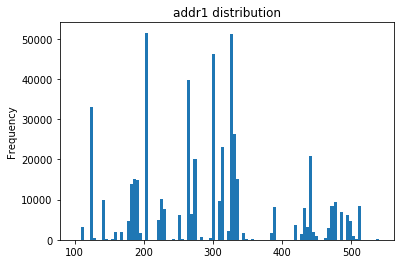

In [80]:
#distribution of address 1
addr1 = train_transaction['addr1']
addr1.plot(kind='hist',bins = 100,title='addr1 distribution')

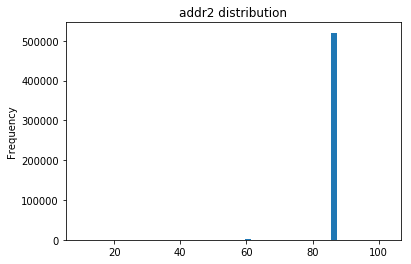

In [81]:
#distribution of address 2
addr2 = train_transaction['addr2']
addr2.plot(kind='hist',bins = 50,title='addr2 distribution')

In the data description it is mentioned that addr1 - addr2 as categorical. However, by the distribution the data kind of looks to be numerical. 

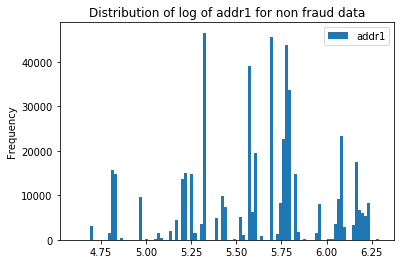

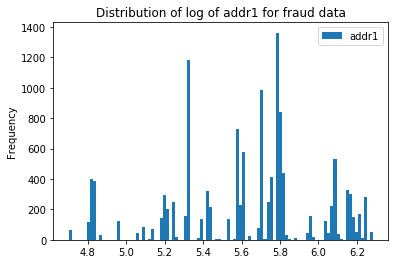

In [82]:
addr_1_dist = train_transaction[train_transaction["isFraud"] == 0]['addr1'].apply(np.log).to_frame()
addr_1_dist.plot(kind='hist',bins=100,title='Distribution of log of addr1 for non fraud data')

#distribution for fraudulent data
addr1_dist = train_transaction[train_transaction["isFraud"] == 1]['addr1'].apply(np.log).to_frame()
addr1_dist.plot(kind='hist',bins=100,title='Distribution of log of addr1 for fraud data')

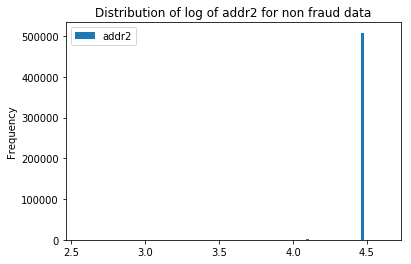

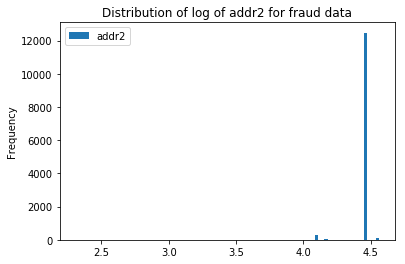

In [83]:
addr_2_dist = train_transaction[train_transaction["isFraud"] == 0]['addr2'].apply(np.log).to_frame()
addr_2_dist.plot(kind='hist',bins=100,title='Distribution of log of addr2 for non fraud data')

#distribution for fraudulent data
addr2_dist = train_transaction[train_transaction["isFraud"] == 1]['addr2'].apply(np.log).to_frame()
addr2_dist.plot(kind='hist',bins=100,title='Distribution of log of addr2 for fraud data')

**Analysis of dist1 / dist2 (some form of distance - address, zip code, IP, phone, …)**

In [84]:
dist_1 = train_transaction['dist1'].tolist()
dist_1_lst = []
print('number if unique dist1 codes:',len(train_transaction['dist1'].unique().tolist()))
count=0
for item in dist_1:
    if str(item) == 'nan':
        count += 1
    else:
        dist_1_lst.append(item)

dist_2 = train_transaction['dist2'].tolist()
dist_2_lst = []
print('number if unique dist2 codes:',len(train_transaction['dist2'].unique().tolist()))
count1=0
for item in dist_2:
    if str(item) == 'nan':
        count1 += 1
    else:
        dist_2_lst.append(item)

print('Number of dist1 fields with empty values',count)
print('Number of dist2 fields with empty values',count1)

number if unique dist1 codes: 2652
number if unique dist2 codes: 1752
Number of dist1 fields with empty values 352271
Number of dist2 fields with empty values 552913


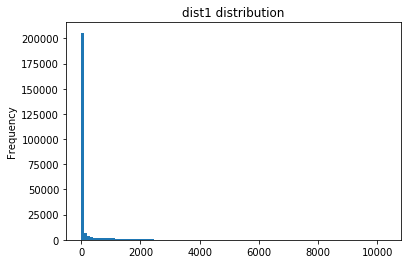

In [85]:
#distribution of dist 1
dist1 = train_transaction['dist1']
dist1.plot(kind='hist',bins = 100,title='dist1 distribution')

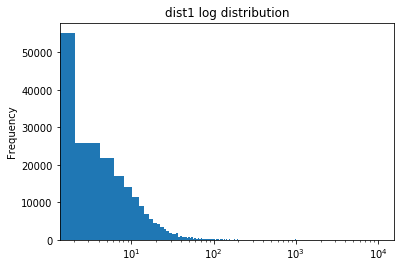

In [86]:
#log distribution of dist 1
dist1_1 = train_transaction['dist1']
dist1_1.plot(kind='hist',bins = 5000,title='dist1 log distribution',logx=True)

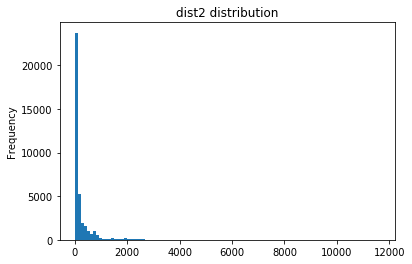

In [87]:
#distribution of dist 2
dist2 = train_transaction['dist2']
dist2.plot(kind='hist',bins = 100,title='dist2 distribution')

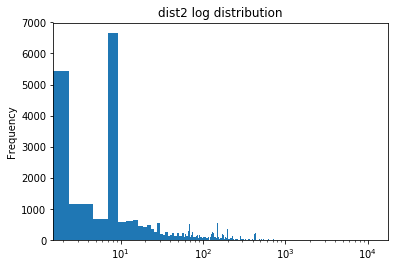

In [88]:
#log distribution of dist 2
dist1_2 = train_transaction['dist2']
dist1_2.plot(kind='hist',bins = 5000,title='dist2 log distribution',logx=True)

From the above distributions, it is observed that log distribution is giving better visualization. It is not clear what this attribute describes, but it might be distance from card owner's personal address to the location where transaction was made.

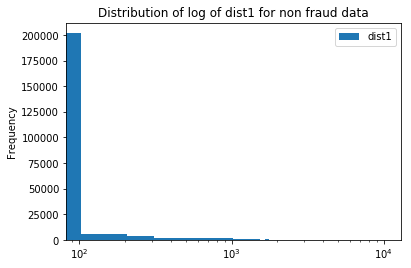

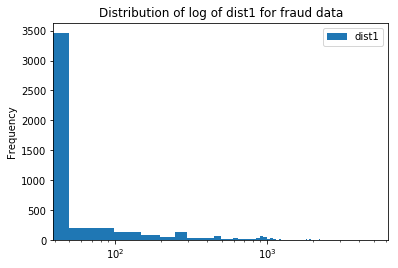

In [89]:
dist_1_dist = train_transaction[train_transaction["isFraud"] == 0]['dist1'].to_frame()
dist_1_dist.plot(kind='hist',bins=100,title='Distribution of log of dist1 for non fraud data',logx=True)

#distribution for fraudulent data
dist1_dist = train_transaction[train_transaction["isFraud"] == 1]['dist1'].to_frame()
dist1_dist.plot(kind='hist',bins=100,title='Distribution of log of dist1 for fraud data',logx=True)

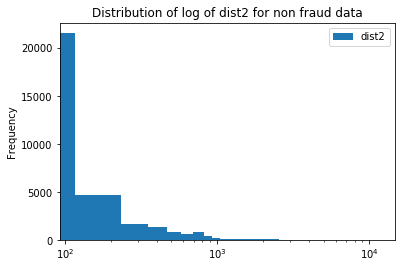

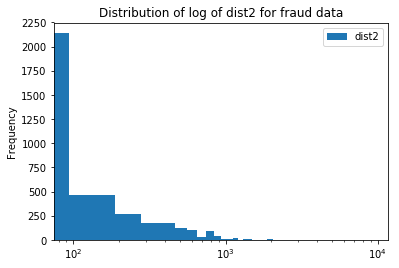

In [90]:
dist_2_dist = train_transaction[train_transaction["isFraud"] == 0]['dist2'].to_frame()
dist_2_dist.plot(kind='hist',bins=100,title='Distribution of log of dist2 for non fraud data',logx=True)

#distribution for fraudulent data
dist2_dist = train_transaction[train_transaction["isFraud"] == 1]['dist2'].to_frame()
dist2_dist.plot(kind='hist',bins=100,title='Distribution of log of dist2 for fraud data',logx=True)

## Part 2 - Transaction Frequency

most frequent country code: 87.0


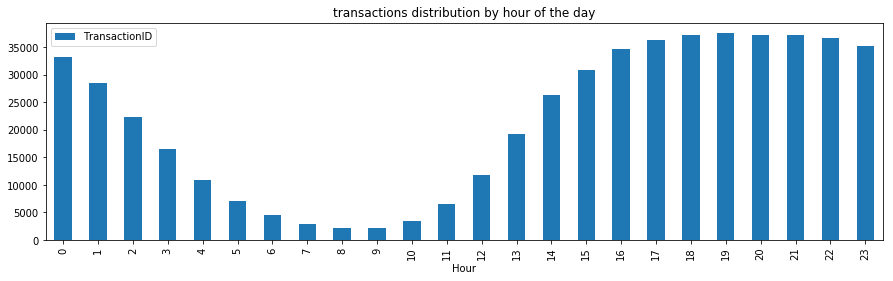

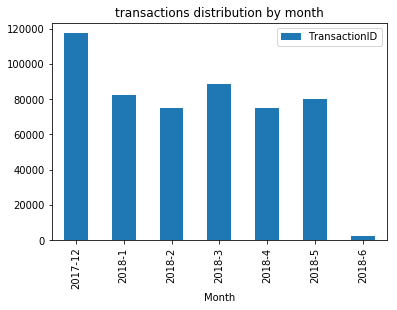

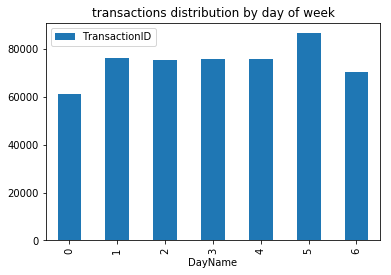

In [91]:
#calculating the most frequent country code

freq_addr2 = Counter(addr_2_lst).most_common(1)
print('most frequent country code:',freq_addr2[0][0])


#fraud transactions by hour for train data
dist_by_hour=train_transaction[train_transaction["addr2"] == freq_addr2[0][0]].groupby('Hour')['TransactionID'].count().to_frame()
dist_by_hour.plot(kind='bar', fontsize=10,figsize=(15,4), title='transactions distribution by hour of the day')

#fraud transactions by month for train data
dist_by_month = train_transaction[train_transaction["addr2"] == freq_addr2[0][0]].groupby('Month')['TransactionID'].count().to_frame()
dist_by_month.plot(kind='bar', fontsize=10, title='transactions distribution by month')

train_transaction['DayName'] = train_transaction['Date'].dt.weekday

#fraud transactions by day of week for train data
dist_by_month = train_transaction[train_transaction["addr2"] == freq_addr2[0][0]].groupby('DayName')['TransactionID'].count().to_frame()
dist_by_month.plot(kind='bar', fontsize=10, title='transactions distribution by day of week')

**From the above observations we can say that:**
1. If we see the number of transactions by hour of the day, and if we assume there is no relative difference between the country's time and time reference of the data, then we can say that transactions increase after noon and are at peak during evening and decrease over night. Also, the early morning hours see the least transactions which is understandable as people won't shop early morning. But seeing that we are observing reasonably good number of transactions during 3 am to 5 am, we can just assume that if at max there is any relative difference of time between delta given and the country code, it can be at max 2-3 hours, with the country's time being 2-3 hours behind the delta reference.
2. If we observe the number of transactions by month, we see that the country made the highest number of transactions during December. December is the christmas season for countries like US, UK and tend to see maximum number of shopping.
3. From the distribution of transactions by day, we see maximum transactions occur during Friday. Usually in countries like US we observe that there are special deals during Fridays, known as black fridays, so this might be a possibility.

**From the above 3 points we can assume and infer that most probably the country code with most frequent transactions is US in this data set. It is possible that it can be some other country as well**

Hour  isFraud
0     0         0.979
      1         0.021
1     0         0.979
      1         0.021
2     0         0.979
      1         0.021
3     0         0.978
      1         0.022
4     0         0.972
      1         0.028
5     0         0.964
      1         0.036
6     0         0.961
      1         0.039
7     0         0.943
      1         0.057
8     0         0.953
      1         0.047
9     0         0.935
      1         0.065
10    0         0.960
      1         0.040
11    0         0.970
      1         0.030
12    0         0.973
      1         0.027
13    0         0.980
      1         0.020
14    0         0.981
      1         0.019
15    0         0.980
      1         0.020
16    0         0.978
      1         0.022
17    0         0.977
      1         0.023
18    0         0.975
      1         0.025
19    0         0.975
      1         0.025
20    0         0.977
      1         0.023
21    0         0.975
      1         0.025
22    0         0.

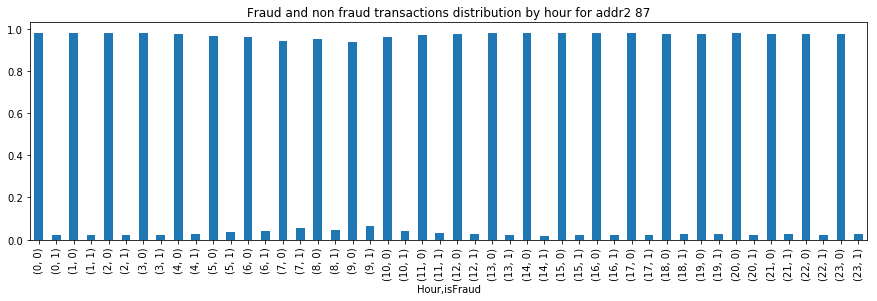

In [92]:
#fraud transactions by hour for train data
dist_by_hour = train_transaction[train_transaction["addr2"] == freq_addr2[0][0]].groupby('Hour')['isFraud'].value_counts(normalize=True)
dist_by_hour.plot(kind='bar', fontsize=10,figsize=(15,4), title='Fraud and non fraud transactions distribution by hour for addr2 87')
dist_by_hour.T

Month   2017-12       2018-1       2018-2  ... 2018-4 2018-5       2018-6      
isFraud       0     1      0     1      0  ...      1      0     1      0     1
isFraud   0.983 0.017  0.971 0.029  0.971  ...  0.023  0.978 0.022  0.970 0.030

[1 rows x 14 columns]

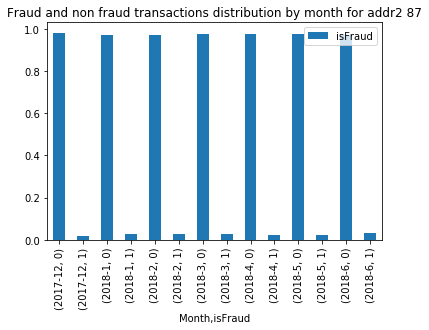

In [93]:
#fraud transactions by month for train data
dist_by_month = train_transaction[train_transaction["addr2"] == 
                                  freq_addr2[0][0]].groupby('Month')['isFraud'].value_counts(normalize=True).to_frame()
dist_by_month.plot(kind='bar', fontsize=10, title='Fraud and non fraud transactions distribution by month for addr2 87')
dist_by_month.T

DayName     0           1           2        ...     4           5           6      
isFraud     0     1     0     1     0     1  ...     0     1     0     1     0     1
isFraud 0.975 0.025 0.978 0.022 0.978 0.022  ... 0.975 0.025 0.976 0.024 0.975 0.025

[1 rows x 14 columns]

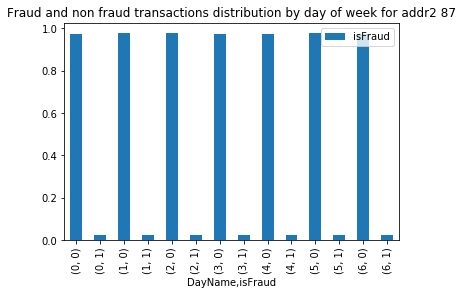

In [94]:
#fraud transactions by day of week for train data
dist_by_month = train_transaction[train_transaction["addr2"] == 
                                  freq_addr2[0][0]].groupby('DayName')['isFraud'].value_counts(normalize=True).to_frame()
dist_by_month.plot(kind='bar', fontsize=10, title='Fraud and non fraud transactions distribution by day of week for addr2 87')
dist_by_month.T

**From the above observations we can say that:**
1. If we see the number of transactions by hour of the day, we observe that 9 am sees the maximum number of fraud transactions with 6.5% and 2 pm in the afternoon sees the least number of fraud transactions at 1.9%.
2. If we observe the number of transactions by month, we observe that Jan and Feb sees the maximum number of fraud transactions with 2.9% and December sees the least number of fraud transactions at 1.7%.
3. From the distribution of transactions by day, we observe that Wednesday sees the maximum number of fraud transactions with 2.6% and Monday and Tueday sees the least number of fraud transactions at 2.2%.

## Part 3 - Product Code

In [95]:
#fraud transactions by hour for train data
prd_cd = train_transaction['ProductCD'].unique().tolist()
print('unique product codes:',prd_cd)

unique product codes: ['W', 'H', 'C', 'S', 'R']


Total number of transactions per product code!
{'C': 68519, 'H': 33024, 'R': 37699, 'S': 11628, 'W': 439670}

Total amount of transactions per product code!
{'C': 2937570.762999902, 'H': 2416368.0, 'R': 6344975.0, 'S': 700813.5999999999, 'W': 67339221.37221125}

amount of one transaction per product code!
{'C': 42.872353113733446, 'H': 73.17005813953489, 'R': 168.30618849306347, 'S': 60.269487444100434, 'W': 153.15855385223293}


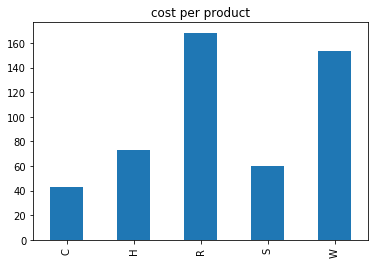

In [96]:
print('Total number of transactions per product code!')
prd_cd_dist = train_transaction.groupby('ProductCD')['TransactionID'].count()
dict_1 = prd_cd_dist.to_dict()
print(dict_1)
print()
print('Total amount of transactions per product code!')
prd_cd_amt = train_transaction.groupby('ProductCD')['TransactionAmt'].sum()
dict_2 = prd_cd_amt.to_dict()
print(dict_2)
dict_3 = {}
for i in dict_1:
    dict_3[i] = dict_2[i]/dict_1[i]
print()
print('amount of one transaction per product code!')
print(dict_3)

cost_of_prd = pd.Series(dict_3)
cost_of_prd.plot(kind='bar',title='cost per product')

**From the above calculations we can say that**
1. Product R is the most expensive product with per unit approximately price being 168.3 units
2. Prodcut C is the cheapest with per unit price approximately being 42.87 units

**Assumption: Mostly people buy 1 unit of a product per transaction. So the above conclusions are approximated on the basis that each transaction included 1 unit of the particular product**

## Part 4 - Correlation Coefficient

transaction amount by hour of the day!


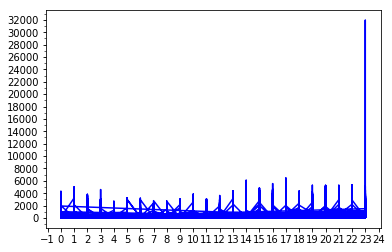

In [97]:
#transaction amount by hour for train data
print('transaction amount by hour of the day!')
X = train_transaction['Hour']
Y = train_transaction['TransactionAmt']
#train_transaction.head()
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2000))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1000))
plt.plot(X, Y, c='blue')
plt.show()

In [98]:
#10 highest transaction amounts and their time
trn_amt = train_transaction['TransactionAmt'].to_list()
trn_amt = list(set(trn_amt))
trn_amt.sort(reverse=True)
print('top 10 highest transaction amounts')
for i in range(0,10):
    time = train_transaction[train_transaction['TransactionAmt']==trn_amt[i]]['Hour']
    time = time.to_list()
    print('$',str(trn_amt[i]),'and the transactions occurred in the following hours:',time)

top 10 highest transaction amounts
$ 31937.391 and the transactions occurred in the following hours: [23, 23]
$ 6450.97 and the transactions occurred in the following hours: [17]
$ 6085.23 and the transactions occurred in the following hours: [14]
$ 5543.23 and the transactions occurred in the following hours: [16]
$ 5420.0 and the transactions occurred in the following hours: [14, 14]
$ 5366.82 and the transactions occurred in the following hours: [22]
$ 5279.95 and the transactions occurred in the following hours: [19, 20, 17]
$ 5278.95 and the transactions occurred in the following hours: [21]
$ 5277.95 and the transactions occurred in the following hours: [22]
$ 5191.0 and the transactions occurred in the following hours: [20, 20]


In [99]:
print('correlation between amount of transaction and hour of the day!')
print()
corr_amt = train_transaction['TransactionAmt'].corr(train_transaction['Hour'],method='pearson')
print('1: correlation coefficient by pearson method:',corr_amt)
corr_amt = train_transaction['TransactionAmt'].corr(train_transaction['Hour'],method='kendall')
print('2: correlation coefficient by kendall method:',corr_amt)
corr_amt = train_transaction['TransactionAmt'].corr(train_transaction['Hour'],method='spearman')
print('3: correlation coefficient by spearman method:',corr_amt)

correlation between amount of transaction and hour of the day!

1: correlation coefficient by pearson method: 0.04453235603065289
2: correlation coefficient by kendall method: 0.026512115774785423
3: correlation coefficient by spearman method: 0.038320230107218904


## Part 5 - Interesting Plot

From our above analysis we have observed that the transactions are periodic in nature and can be distributed against time like hours of the day or the weekday.

Below we try to find the correlation between number of fraud transactions and the day of week.

1: correlation coefficient for fraud transactions by day of week by pearson method: 0.00724795926320868
1: correlation coefficient for fraud transactions by day of week by kendall method: 0.00639705524858664
1: correlation coefficient for fraud transactions by day of week by spearman method: 0.0073254738047321515


Text(0, 0.5, 'fraction of fradulent transactions')

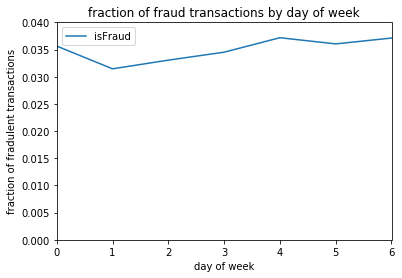

In [100]:
corr_amt = train_transaction['isFraud'].corr(train_transaction['DayName'],method='pearson')
print('1: correlation coefficient for fraud transactions by day of week by pearson method:',corr_amt)

corr_amt = train_transaction['isFraud'].corr(train_transaction['DayName'],method='kendall')
print('1: correlation coefficient for fraud transactions by day of week by kendall method:',corr_amt)

corr_amt = train_transaction['isFraud'].corr(train_transaction['DayName'],method='spearman')
print('1: correlation coefficient for fraud transactions by day of week by spearman method:',corr_amt)

fraud_day = train_transaction.groupby('DayName').mean()['isFraud'].to_frame()
ax = fraud_day.plot(kind='line',ylim = (0,0.04),title = 'fraction of fraud transactions by day of week')
ax.set_xlabel("day of week")
ax.set_ylabel("fraction of fradulent transactions")

From the above observation it is clear that number of fraud transactions and the day of the week don't have that much of a correlation, hence we can say that day of week is not a useful parameter to measure on.

**Now, we will check the fraction of fradulent transactions with respect to hour of the day**

Text(0, 0.5, 'No. of transactions')

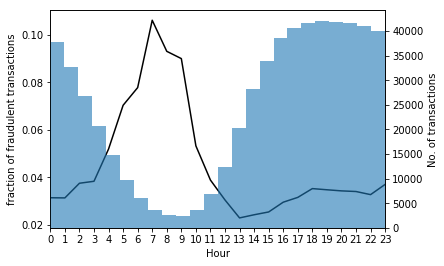

In [101]:
hrs = train_transaction['Hour'].to_list()
bins_num = list(set(hrs))

trn_by_hr = train_transaction.groupby('Hour').mean()['isFraud']
trn_by_hr.plot(color='black')
ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(train_transaction['Hour'], alpha=0.6,bins = len(bins_num))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xlabel('Hour')
ax.set_ylabel('fraction of fraudulent transactions')
ax2.set_ylabel('No. of transactions')

Here we observe that fraction of fraud transactions shows a good amount of variation with hour of the day. This is an important finding which can be used in the predictive models.
Also, the lower the number of transactions, the higher is the fradulency. This may indicate third party fraud transactions.

**Thus, hour of day is an important parameter to consider in the predictive models**

## Part 6 - Prediction Model

In [0]:
#data preprocessing
from sklearn import preprocessing
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

#cleaning the prior data loaded to free up memory
del train_identity, train_transaction, test_identity, test_transaction

train_transaction = pd.read_csv('/content/drive/My Drive/DS_HW1/ieee-fraud-detection/train_transaction.csv')
test_transaction = pd.read_csv('/content/drive/My Drive/DS_HW1/ieee-fraud-detection/test_transaction.csv')
train_identity = pd.read_csv('/content/drive/My Drive/DS_HW1/ieee-fraud-detection/train_identity.csv')
test_identity =  pd.read_csv('/content/drive/My Drive/DS_HW1/ieee-fraud-detection/test_identity.csv')
sample_submission = pd.read_csv('/content/drive/My Drive/DS_HW1/ieee-fraud-detection/sample_submission.csv')

train_trn_id_merged = pd.merge(train_transaction, train_identity, on=['TransactionID'], how='left')
test_trn_id_merged = pd.merge(test_transaction, test_identity, on=['TransactionID'], how='left')

del train_identity, train_transaction, test_identity, test_transaction


y_train = train_trn_id_merged['isFraud'].copy()
X_train = train_trn_id_merged.drop('isFraud', axis=1)

**Below is the model for prediction**

In [0]:
#xg boost model
model = xgb.XGBClassifier(max_depth=9, 
 learning_rate=0.05, 
 n_estimators=500, 
 verbosity=1, 
 silent=None, 
 objective='binary:logistic', 
 booster='gbtree', 
 n_jobs=1, 
 nthread=None, 
 gamma=0, 
 min_child_weight=1, 
 max_delta_step=0, 
 subsample=0.9, 
 colsample_bytree=1, 
 colsample_bylevel=1, 
 colsample_bynode=1, 
 reg_alpha=0, 
 reg_lambda=1, 
 scale_pos_weight=1, 
 base_score=0.5, 
 random_state=2019, 
 seed=None, 
 missing=-999, 
 tree_method='gpu_hist')

**Testing the model by splitting the training data set into 500000 records for training and the remaining for testing.**

In [0]:
y_demo_train = y_train.head(500000)
y_demo_test = y_train.tail(90540)
X_demo_train = X_train[:500000]
X_demo_test = X_train[500000:]

In [0]:
X_demo_train = X_demo_train.fillna(-999)
X_demo_test = X_demo_test.fillna(-999)

#making labels
for col in X_demo_train.columns:
    if X_demo_train[col].dtype=='object' or X_demo_test[col].dtype=='object': 
        label_enc = preprocessing.LabelEncoder()
        label_enc.fit(list(X_demo_train[col].values) + list(X_demo_test[col].values))
        X_demo_train[col] = label_enc.transform(list(X_demo_train[col].values))
        X_demo_test[col] = label_enc.transform(list(X_demo_test[col].values))

In [107]:
#model fitting
%time model.fit(X_demo_train, y_demo_train,verbose=True)

CPU times: user 7min 43s, sys: 5min 38s, total: 13min 22s
Wall time: 13min 22s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-999, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2019,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, tree_method='gpu_hist', verbosity=1)

In [0]:
predictions = model.predict(X_demo_test)

**Below is the preformance of the model on the testing set created from the given data.**

In [109]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
print('accuracy:',accuracy_score(y_demo_test, predictions)*100)
print('root mean sqaured error:',mean_squared_error(y_demo_test, predictions))
print('roc score:',roc_auc_score(y_demo_test, predictions))

accuracy: 97.67947868345482
root mean sqaured error: 0.023205213165451734
roc score: 0.6975687938067268


In [110]:
#cleaning up
del X_demo_train, X_demo_test, y_demo_train, y_demo_test
gc.collect()

58412

**Now preparing the data and predicting for actual kaggle submission**

In [0]:
X_test = test_trn_id_merged.copy()
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)
#making labels
for col in X_train.columns:
    if X_train[col].dtype=='object' or X_test[col].dtype=='object':
        label_enc = preprocessing.LabelEncoder()
        label_enc.fit(list(X_train[col].values) + list(X_test[col].values))
        X_train[col] = label_enc.transform(list(X_train[col].values))
        X_test[col] = label_enc.transform(list(X_test[col].values))

In [113]:
#model fitting
%time model.fit(X_train, y_train,verbose=True)

CPU times: user 8min 43s, sys: 6min 26s, total: 15min 10s
Wall time: 15min 10s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-999, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2019,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, tree_method='gpu_hist', verbosity=1)

In [0]:
#class prediction
sample_submission['isFraud'] = model.predict_proba(X_test)[:,1]

In [0]:
#writing to csv file
sample_submission.to_csv('submission.csv')

In [0]:
#downloading the csv file
from google.colab import files
files.download('submission.csv')

Model desciption

1.   **objective function used: binary:logistic:** logistic regression for binary classification which gives output probability.
Here we are computing an approximation of the real underlying algorithm and this helps in reducing the fitting time.

2.   **booster :Used gbtree** which uses tree based models

3.   **learning rate of 0.05** was giving the highest roc_auc score

4.   **max_depth = 0.9**, which is the depth of the tree model and thereby of increased complexity

5.   **tree_method: gpu_hist**, this uses the hist algorithm for tree construction and also uses the GPU. This activates the GPU usage and reduces time from ~3500sec to ~40sec

6.   **ROC_AUC score**: 0.9381 (highest out of many attempts)
Since it was crashing on kaggle on GPU activation, this model also reduced the RAM usage and prevent on any crashes.

7.   **Gamma was chosen to be 0:** This made the loss minimum during leaf node partitioning.

8.   **Subsample was chosen to be 0.9**: this made the XGBoost to sample almost all of the sampling data before growing the trees and helped prevent overfitting.


9.   **base_score was chosen to be 0.5**: since we saw in the sample submission file given that the initial prediction was given as 0.5, so I chose the base score as 0.5 here as well

10.   **n_estimators was chosen to be 500:** it was observed that choosing the number of trees to fit as 500 was giving the peak result. Increasing or lowering this value decreased the score.

11.   Filled all the empty or nan values in the data by -999 and mentioned the same in the model using the missing parameter.








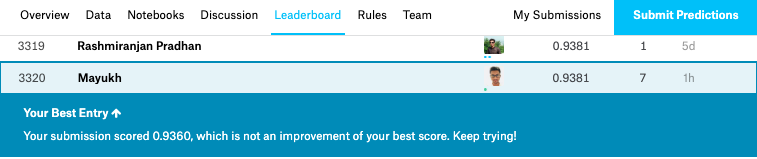

In [120]:
from IPython.display import Image
Image('/content/drive/My Drive/DS_HW1/ieee-fraud-detection/roc_auc_ran.png')

## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: https://www.kaggle.com/mayukhmaitra18/account

Highest Rank: 3320

Score: 0.9381

Number of entries: 7

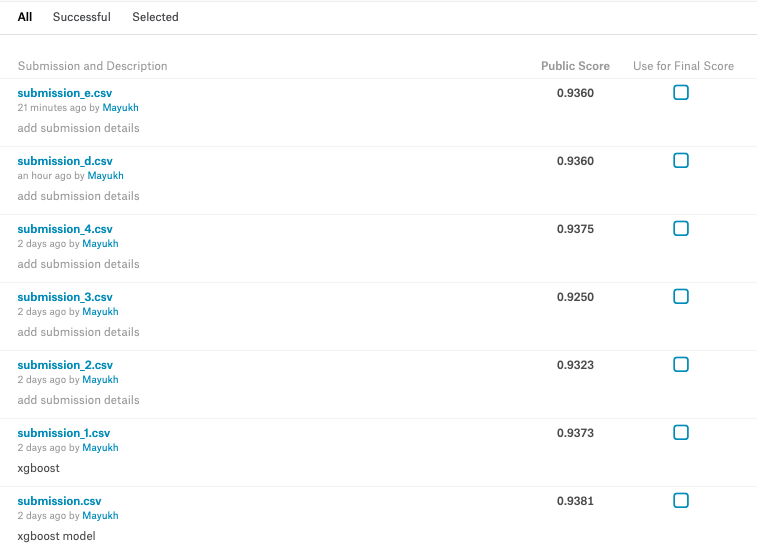

In [121]:
from IPython.display import Image
Image('/content/drive/My Drive/DS_HW1/ieee-fraud-detection/submissions.png')

INCLUDE IMAGE OF YOUR KAGGLE RANKING

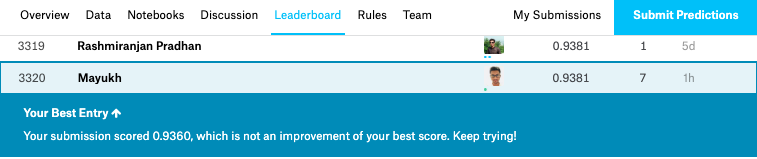

In [122]:
from IPython.display import Image
Image('/content/drive/My Drive/DS_HW1/ieee-fraud-detection/roc_auc_ran.png')